# Problem Statment

Text about what the problem is and how we are going to solve it.

---
---

# Code

#### imports

In [78]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

## EDA

#### retrieve the data

In [17]:
# fetch dataset support
data = fetch_ucirepo(id=880) 

# data (as pandas dataframes) 
X = data.data.features.copy()
y = data.data.targets.copy()

pandas.core.frame.DataFrame

#### examining the X component

In [3]:
X.head(2)

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,7.0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,1.0


In [7]:
# shape of X
X.shape

(9105, 42)

In [10]:
print(X.dtypes)

# summary statistics for numerical columns
print(X.describe())

# check for missing values
print(X.isnull().sum())

age         float64
sex          object
dzgroup      object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
dtype: object
               age       num.co          edu        scoma       charges  \
count  9105.000000  9105.000000  7471.000000  9104.000000  8.933000e+03

In [11]:
# getting numeric columns only

X_num = X.select_dtypes(include=['float64', 'int64'])
X_num.head(2)

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
0,62.84998,0,11.0,0.0,9715.0,NaN,NaN,7.0,33.898438,20.0,...,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,7.0
1,60.33899,2,12.0,44.0,34496.0,NaN,NaN,29.0,52.695312,74.0,...,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,1.0


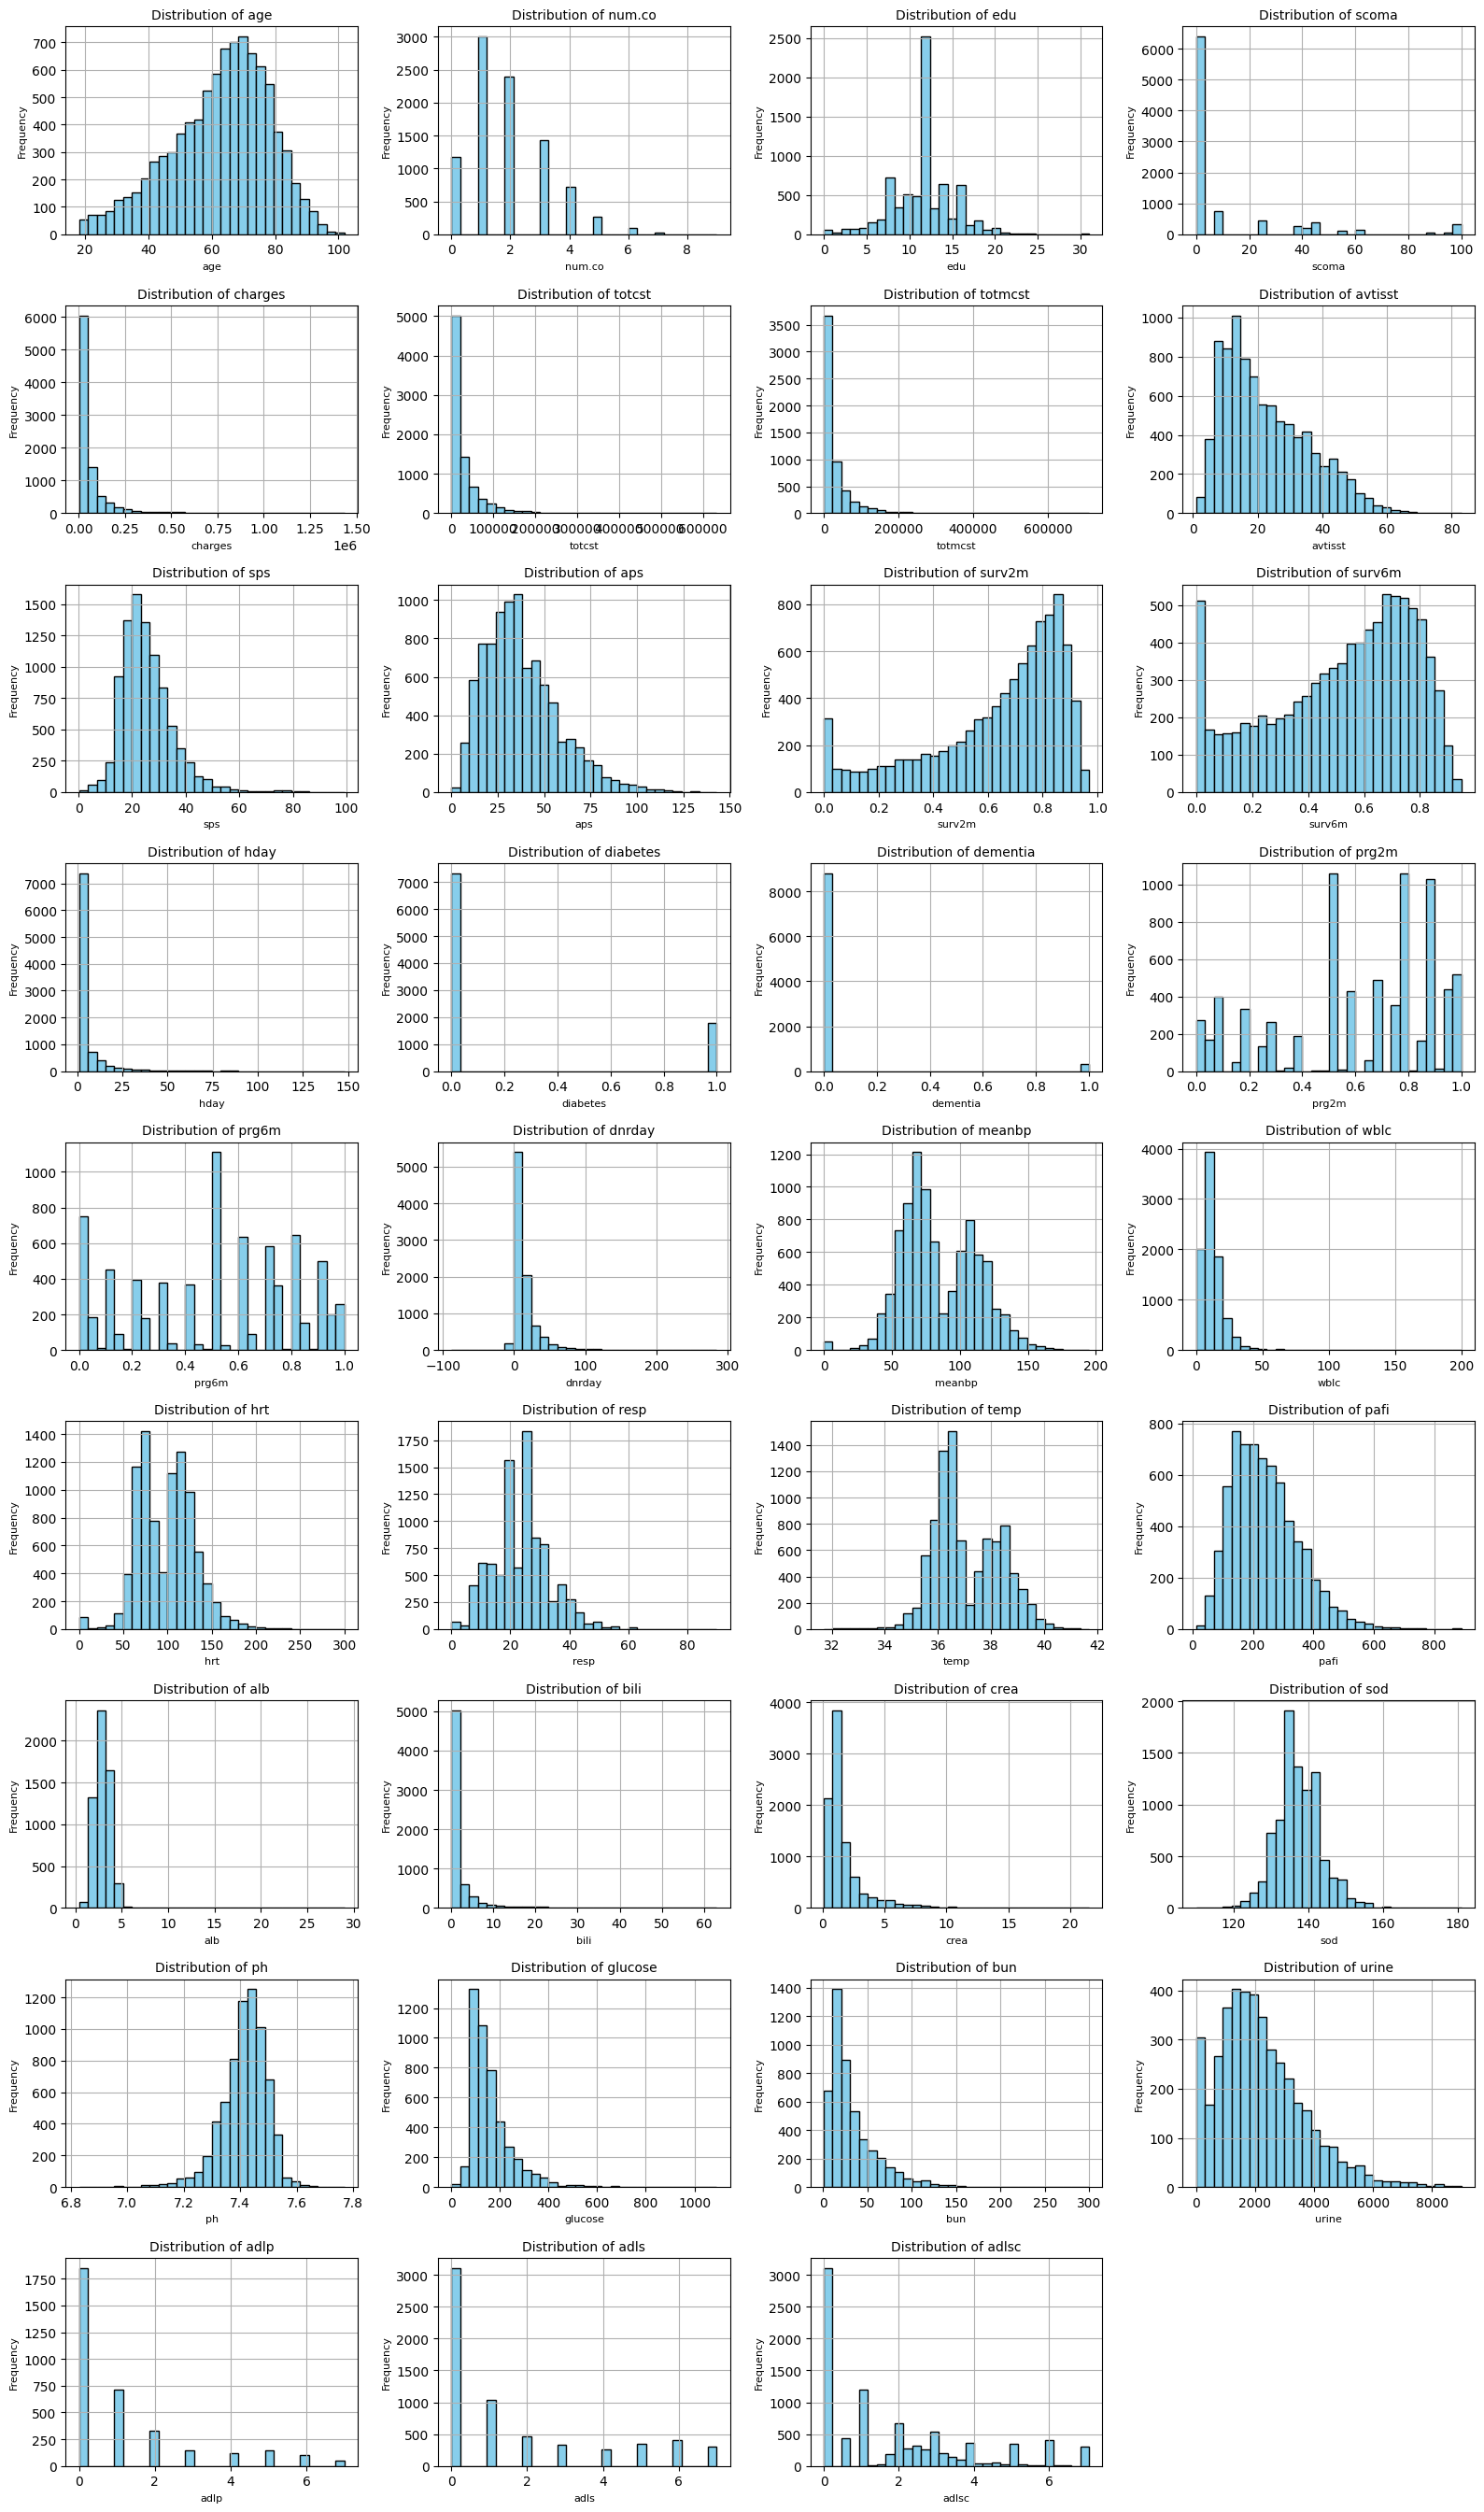

In [18]:
num_cols = len(X.select_dtypes(include='number').columns)
cols = 4  # number of columns in the grid
rows = math.ceil(num_cols / cols)  # calculate rows needed

fig = plt.figure(figsize=(cols * 4, rows * 3))

for i, column in enumerate(X.select_dtypes(include='number').columns, 1):
    ax = fig.add_subplot(rows, cols, i)
    X[column].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel(column, fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)

plt.tight_layout()
plt.show()

#### exploring the target variables

In [6]:
# shape of y
y.head(2)

,death,hospdead,sfdm2
0,0,0,NaN
1,1,1,<2 mo. follow-up


In [8]:
y.death.value_counts()

death
1    6201
0    2904
Name: count, dtype: int64

In [9]:
y.hospdead.value_counts()

hospdead
0    6745
1    2360
Name: count, dtype: int64

## Data Prep & Feature Engineering/Selection

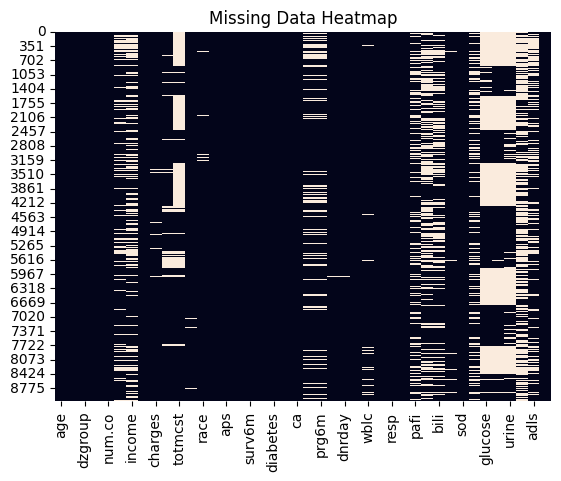

In [19]:
sns.heatmap(X.isnull(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

#### Encoding categorical features

In [21]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical columns based on dtype:", cat_cols)

# Check number of unique values per column
for col in cat_cols:
    unique_vals = X[col].nunique()
    print(f"{col}: {unique_vals} unique values")

Categorical columns based on dtype: ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr']
sex: 2 unique values
dzgroup: 8 unique values
dzclass: 4 unique values
income: 4 unique values
race: 5 unique values
ca: 3 unique values
dnr: 3 unique values


Since the number of categories per categorical column is relatively low, we can encode these columns with one hot encoding. This will create a new column per unique category and designate it with a 0 or 1, 1 indicating that this record belongs to that category.

In [23]:
# Perform One-Hot encoding
X_encoded = pd.get_dummies(X, 
                           columns=cat_cols,
                           dtype=int,
                           drop_first=True
                           )

In [44]:
# verify there are all numeric feature types now
X_encoded.dtypes

age                           float64
num.co                          int64
edu                           float64
scoma                         float64
charges                       float64
totcst                        float64
totmcst                       float64
avtisst                       float64
sps                           float64
aps                           float64
surv2m                        float64
surv6m                        float64
hday                            int64
diabetes                        int64
dementia                        int64
prg2m                         float64
prg6m                         float64
dnrday                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
pafi                          float64
alb                           float64
bili                          float64
crea        

#### correlation map

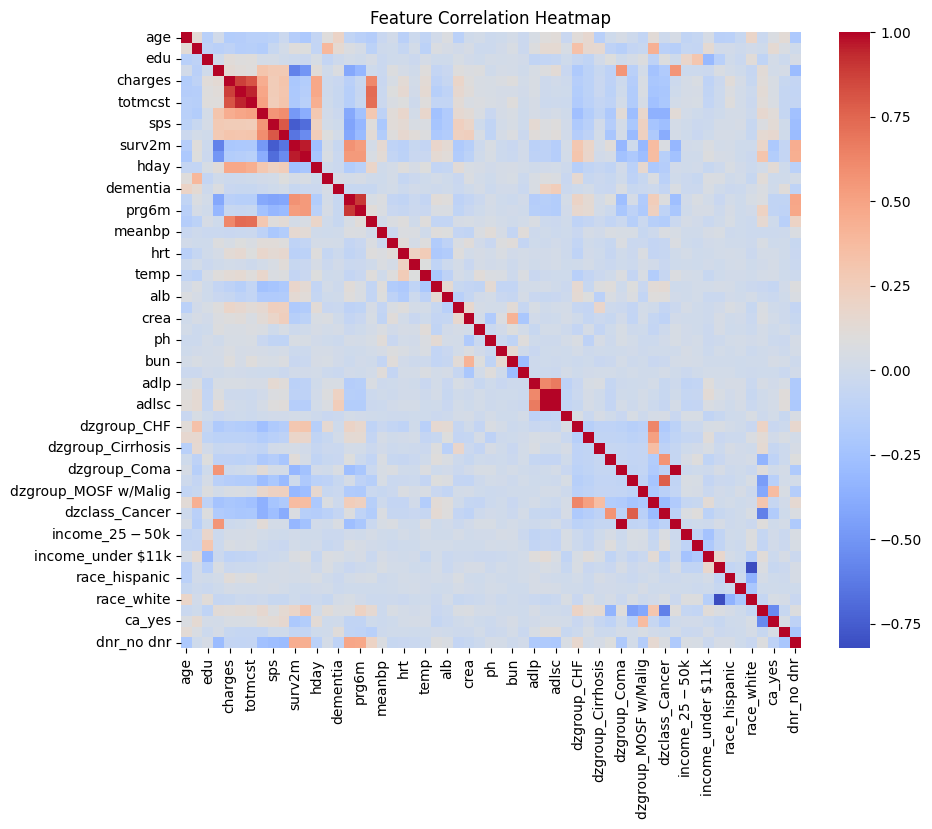

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(X_encoded.corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#### Handling Missing Values

From the data's website there was some default values to fill na's for certain features

In [24]:
X_encoded['alb'] = X_encoded.alb.fillna(3.5)

X_encoded['pafi'] = X_encoded.pafi.fillna(333.3)

X_encoded['bili'] = X_encoded.bili.fillna(1.01)

X_encoded['crea'] = X_encoded.crea.fillna(1.01)

X_encoded['bun'] = X_encoded.bun.fillna(6.51)

X_encoded['wblc'] = X_encoded.wblc.fillna(9)

X_encoded['urine'] = X_encoded.urine.fillna(2502)

In [27]:
total_rows = X_encoded.shape[0]
remaining_rows = X_encoded.dropna().shape[0]
percent_remaining = (remaining_rows / total_rows) * 100

print(f"Rows remaining after dropping NaNs: {remaining_rows} of {total_rows} ({percent_remaining:.2f}%)")

Rows remaining after dropping NaNs: 751 of 9105 (8.25%)


Dropping any row that contained a NaN would wipe out over 90% of the data set. For that reason we will have to impute some of the data.

In [30]:
# Drop columns with more than 80% missing values
missing_threshold = 0.8
X_encoded_dropNA = X_encoded.loc[:, X_encoded.isnull().mean() < missing_threshold].copy()

In [31]:
X_encoded.shape

(9105, 57)

In [32]:
X_encoded_dropNA.shape

(9105, 57)

#### scaling the data

In [34]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_encoded_dropNA)

In [36]:
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X_encoded_dropNA.columns)

In [41]:
impute_knn = KNNImputer(n_neighbors=2)

In [42]:
X_imputed = impute_knn.fit_transform(X_scaled_df)

In [46]:
df_clean = pd.DataFrame(data=X_imputed, columns = X_scaled_df.columns)

#### assessing multicollinearity

In [47]:
# deal with multicolinearity

df_clean_const = add_constant(df_clean)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["feature"] = df_clean_const.columns
vif_df["VIF"] = [variance_inflation_factor(df_clean_const.values, i) for i in range(df_clean_const.shape[1])]

/usr/local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


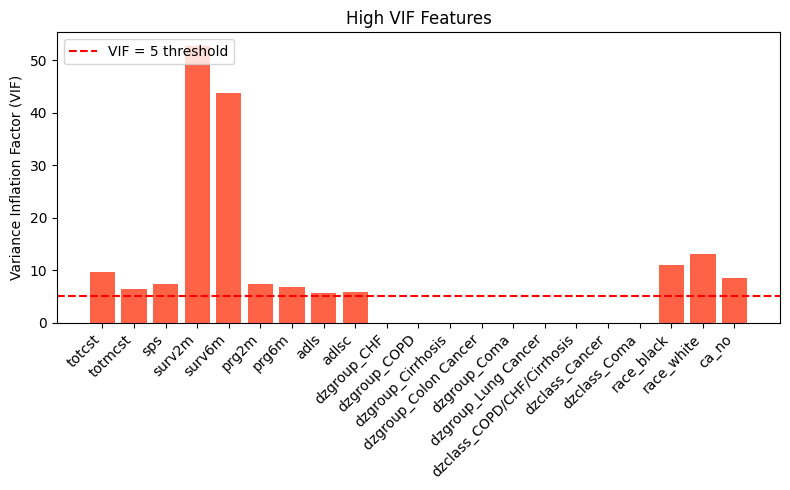

In [48]:
threshold = 5

# Filter the dataframe for VIF > threshold and exclude the constant/intercept if present
high_vif_df = vif_df[(vif_df['VIF'] > threshold) & (vif_df['feature'] != 'const')]

plt.figure(figsize=(8, 5))
plt.bar(high_vif_df['feature'], high_vif_df['VIF'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'VIF = {threshold} threshold')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.title('High VIF Features')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
df_clean['death'] = y['death']
df_clean['hospdead'] = y['hospdead']

df_clean.to_parquet('data/cleaned_output_final_nb.parquet') 

In [72]:
X_final = df_clean.drop(columns=['death', 'hospdead']).copy()

#### feature correlation

In [55]:
correlation_matrix = df_clean.corr()

In [60]:
#correlation_matrix.death

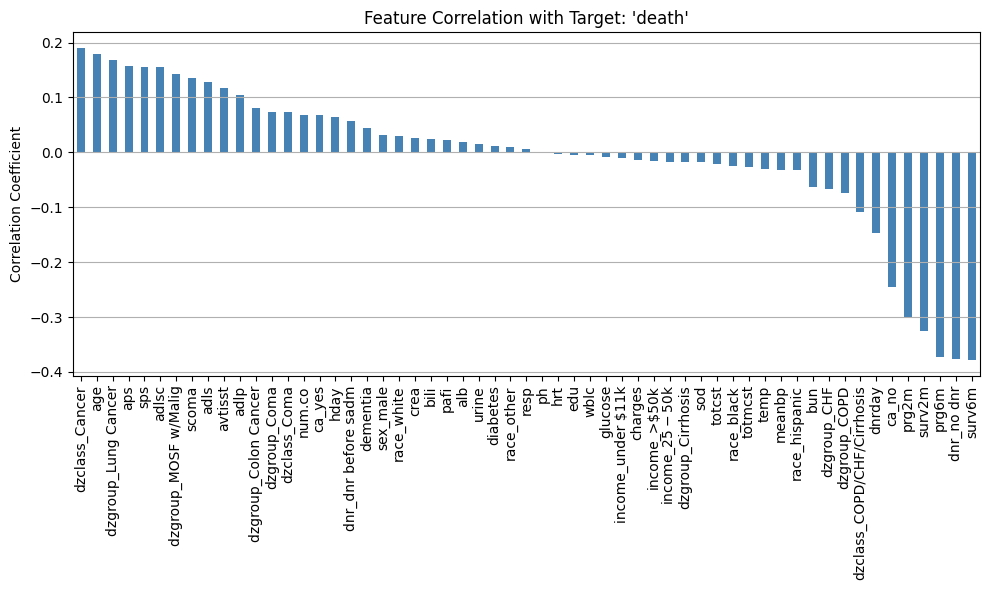

In [56]:
# Plot feature correlation with 'death' as a bar chart

target_corr_death = correlation_matrix['death'].drop(['death', 'hospdead']).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
target_corr_death.plot(kind='bar', color='steelblue')
plt.title("Feature Correlation with Target: 'death'")
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

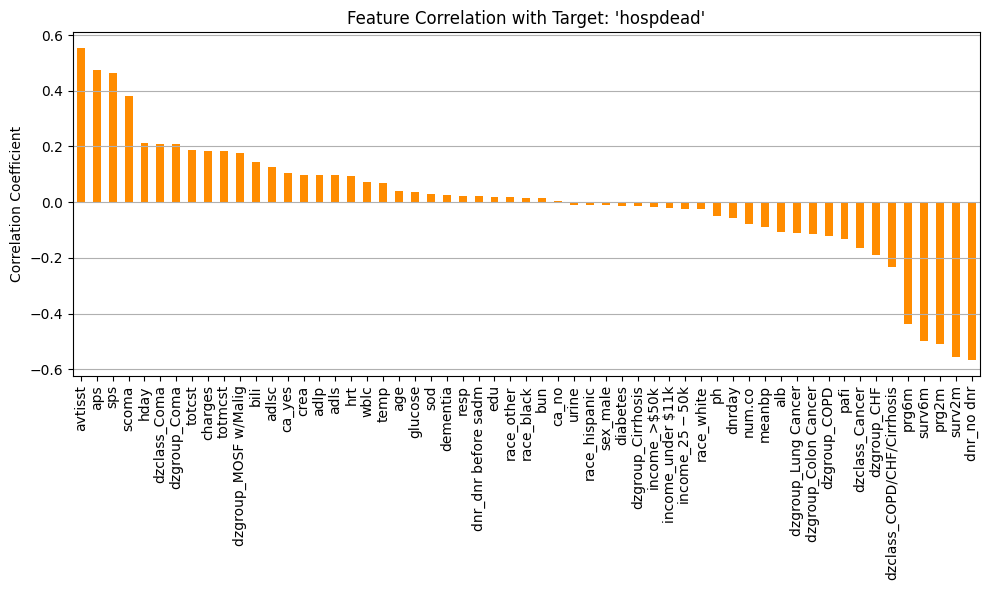

In [57]:
target_corr_hospdead = correlation_matrix['hospdead'].drop(['death', 'hospdead']).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
target_corr_hospdead.plot(kind='bar', color='darkorange')
plt.title("Feature Correlation with Target: 'hospdead'")
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### feature analysis with Random Forest

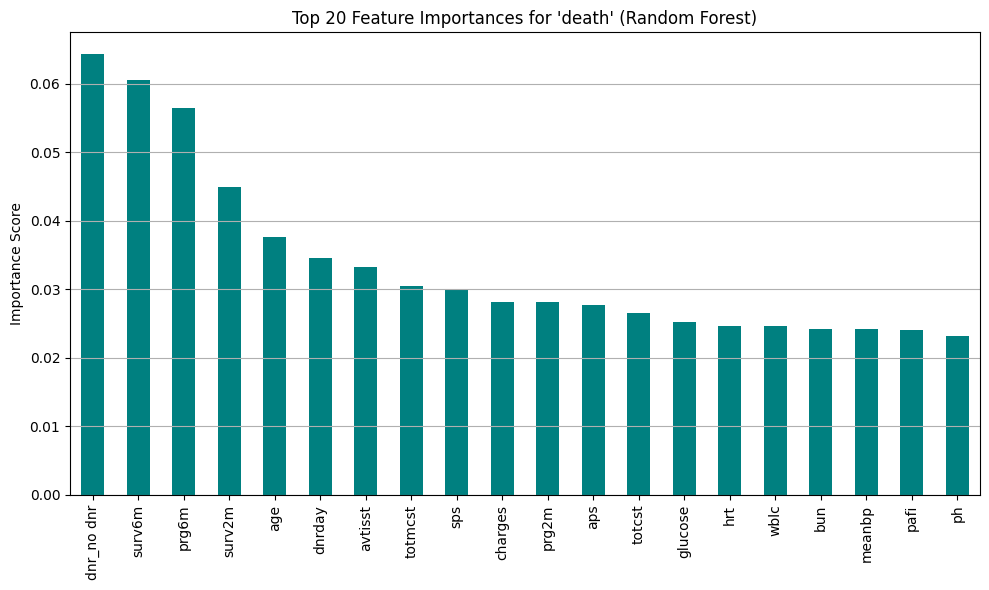

In [75]:


rf_model_death = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_death.fit(X_final, y.death)
feature_importances_death = pd.Series(rf_model_death.feature_importances_, index=X_final.columns)
feature_importances_death_sorted = feature_importances_death.sort_values(ascending=False)

# Visualize feature importance for 'death'
plt.figure(figsize=(10, 6))
feature_importances_death_sorted.head(20).plot(kind='bar', color='teal')
plt.title("Top 20 Feature Importances for 'death' (Random Forest)")
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
ax.set_aspect('auto')
plt.show()

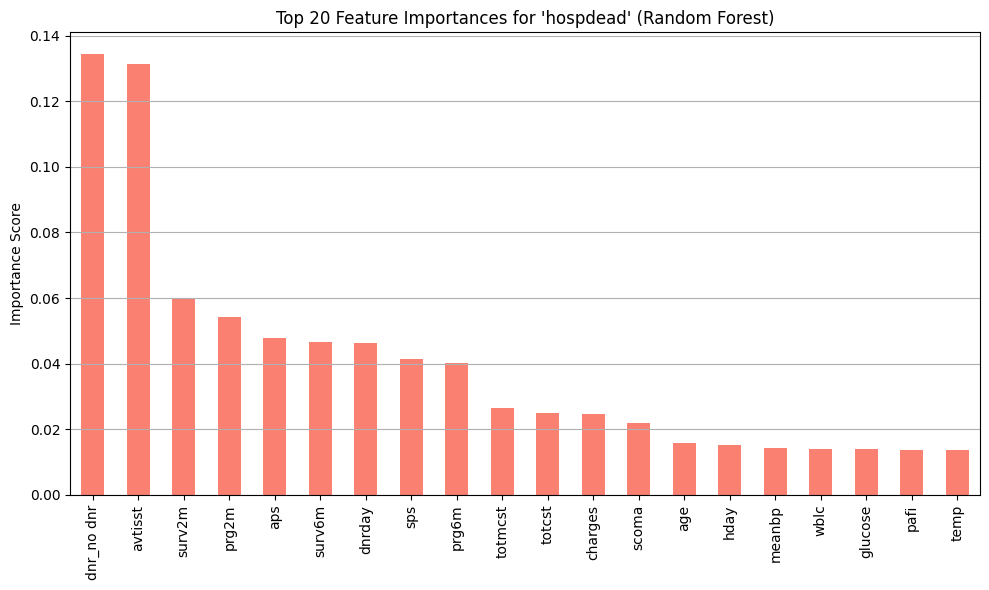

In [77]:
rf_model_hospdead = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_hospdead.fit(X_final, y.hospdead)
feature_importances_hospdead = pd.Series(rf_model_hospdead.feature_importances_, index=X_final.columns)
feature_importances_hospdead_sorted = feature_importances_hospdead.sort_values(ascending=False)

# Step 10: Visualize feature importance for 'hospdead'
plt.figure(figsize=(10, 6))
feature_importances_hospdead_sorted.head(20).plot(kind='bar', color='salmon')
plt.title("Top 20 Feature Importances for 'hospdead' (Random Forest)")
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
ax.set_aspect('auto')
plt.show()

#### analyzing the target variables

Class Distribution for 'death':
death
1    6201
0    2904
Name: count, dtype: int64


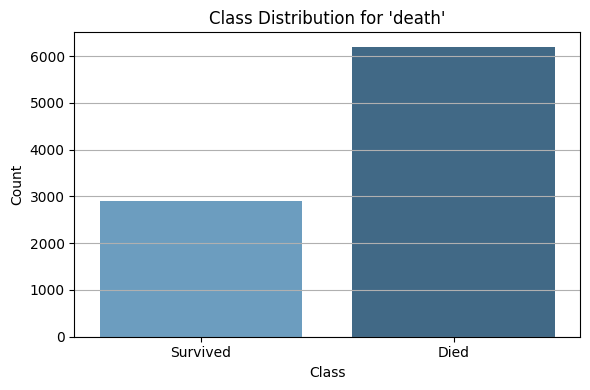

Class Distribution for 'hospdead':
hospdead
0    6745
1    2360
Name: count, dtype: int64


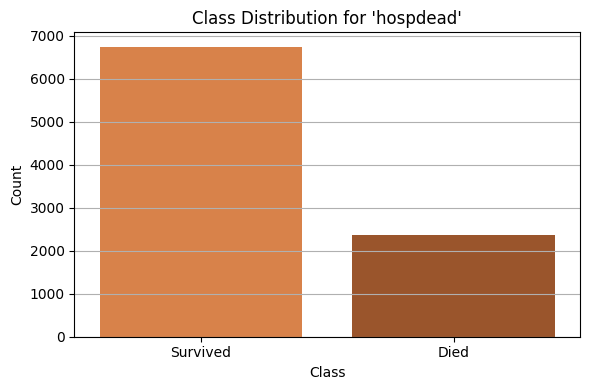

In [63]:
# Check the class distribution for 'death'

death_counts = df_clean['death'].value_counts()
print("Class Distribution for 'death':")
print(death_counts)

#Visualize the class distribution for 'death'

plt.figure(figsize=(6, 4))
sns.barplot(x=death_counts.index, 
            y=death_counts.values,
            hue=death_counts.index,
            palette='Blues_d',
            legend=False
           )
plt.title("Class Distribution for 'death'")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Survived', 'Died'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Check the class distribution for 'hospdead'

hospdead_counts = df_clean['hospdead'].value_counts()
print("Class Distribution for 'hospdead':")
print(hospdead_counts)

# Visualize the class distribution for 'hospdead'

plt.figure(figsize=(6, 4))
sns.barplot(x=hospdead_counts.index, 
            y=hospdead_counts.values,
            hue=hospdead_counts.index,
            palette='Oranges_d',
            legend=False
           )
plt.title("Class Distribution for 'hospdead'")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Survived', 'Died'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Due to the imbalance in the target data, we will balance the data set.

In [79]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]1/2 [imbalanced-learn]


In [80]:
from imblearn.over_sampling import SMOTE

In [82]:
# Apply SMOTE for 'death' target
smote = SMOTE(random_state=42)
X_smote_death, y_smote_death = smote.fit_resample(X_final, y.death)

print("After SMOTE - 'death':")
print(pd.Series(y_smote_death).value_counts())

# Apply SMOTE for 'hospdead' target
X_smote_hospdead, y_smote_hospdead = smote.fit_resample(X_final, y.hospdead)

print("After SMOTE - 'hospdead':")
print(pd.Series(y_smote_hospdead).value_counts())

After SMOTE - 'death':
death
0    6201
1    6201
Name: count, dtype: int64
After SMOTE - 'hospdead':
hospdead
0    6745
1    6745
Name: count, dtype: int64


In [83]:
# Combine features and target
X_smote_death_df = pd.DataFrame(X_smote_death, columns=X_final.columns)
X_smote_death_df['death'] = y_smote_death.values

# Save as Parquet
X_smote_death_df.to_parquet('data/Xy_smote_death_final_nb.parquet')
print("Saved Xy_smote_death.parquet successfully.")


# Save 'hospdead' balanced dataset


# Combine features and target
X_smote_hospdead_df = pd.DataFrame(X_smote_hospdead, columns=X_final.columns)
X_smote_hospdead_df['hospdead'] = y_smote_hospdead.values

# Save as Parquet
X_smote_hospdead_df.to_parquet('data/Xy_smote_hospdead_final_nb.parquet')
print("Saved Xy_smote_hospdead.parquet successfully.")



Saved Xy_smote_death.parquet successfully.
Saved Xy_smote_hospdead.parquet successfully.


## Feature Selection

## Modeling

#### splitting data

In [86]:
val_split = 900 # how many records are being set aside for a validation set

# validation data
val_df = df_clean[-val_split:].copy()

# non validation data
non_val_df = df_clean[:-val_split].copy()

In [90]:
# Assuming df with features and two binary targets: 'death' and 'hospital_death'
X = non_val_df.drop(columns=['death', 'hospdead'])
y_death = non_val_df['death']
y_hosp_death = non_val_df['hospdead']

#####
X_val = val_df.drop(columns=['death', 'hospdead'])
y_val_death = val_df['death']
y_val_hosp_death = val_df['hospdead']


# Train/test split
X_train, X_test, y_train_death, y_test_death, y_train_hosp, y_test_hosp = train_test_split(
    X, y_death, y_hosp_death, test_size=0.2, stratify=y_death, random_state=42)

# the dataset has already been scaled so we won't be doing again

#### Neural Network

In [88]:
input_dim = X_train.shape[1]

inputs = Input(shape=(input_dim,))

# Shared hidden layers with dropout and L2
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)

# Output layers for each task
death_output = layers.Dense(1, activation='sigmoid', name='death')(x)
hospital_death_output = layers.Dense(1, activation='sigmoid', name='hospital_death')(x)

model = models.Model(inputs=inputs, outputs=[death_output, hospital_death_output])

model.compile(
    optimizer='adam',
    loss={
        'death': 'binary_crossentropy',
        'hospital_death': 'binary_crossentropy'
    },
    loss_weights={
        'death': 2.0,               # Prioritize 'death'
        'hospital_death': 1.0       # Less emphasis on 'hospital_death'
    },
    metrics={
        'death': 'AUC',
        'hospital_death': 'AUC'
    }
)

model.summary()

2025-06-16 03:48:05.815371: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      3,712 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ death (Dense)       │ (None, 1)         │         33 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hospital_death      │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,858 (22.88 KB)

 Trainable params: 5,858 (22.88 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# adding callback 
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [93]:
# training
history = model.fit(
    X_train,
    {'death': y_train_death, 'hospital_death': y_train_hosp},
    validation_split=0.2,
    validation_data=(X_val,
                    [y_val_death,y_val_hosp_death]
                    ),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - death_AUC: 0.5923 - death_loss: 0.6529 - hospital_death_AUC: 0.6717 - hospital_death_loss: 0.6066 - loss: 2.0127 - val_death_AUC: 0.8101 - val_death_loss: 0.5318 - val_hospital_death_AUC: 0.8664 - val_hospital_death_loss: 0.3635 - val_loss: 1.5135 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - death_AUC: 0.7585 - death_loss: 0.5288 - hospital_death_AUC: 0.8533 - hospital_death_loss: 0.4175 - loss: 1.5723 - val_death_AUC: 0.8250 - val_death_loss: 0.4970 - val_hospital_death_AUC: 0.8862 - val_hospital_death_loss: 0.3251 - val_loss: 1.4120 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - death_AUC: 0.8005 - death_loss: 0.4982 - hospital_death_AUC: 0.8875 - hospital_death_loss: 0.3698 - loss: 1.4602 - val_death_AUC: 0.8347 - val_death_loss: 0.4963 - val_hospital_death_AUC: 0.8920 - val_hospital_death_loss: 0.3040 - val_loss: 1.3910 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━

## Evaluation

# Conclusion